# Notebook 5: Model Training

## Objective
Fine-tune BERT/RoBERTa for resume classification using our dataset with decision labels.

## Goals
1. Load the full resume screening dataset (10,000+ samples)
2. Prepare training/validation/test splits
3. Fine-tune BERT or RoBERTa for binary classification (Accepted/Rejected)
4. Evaluate model performance (accuracy, F1, precision, recall)
5. Save trained model weights for production

## Dependencies
- `transformers` - Hugging Face transformers library
- `torch` - PyTorch for deep learning
- `datasets` - Hugging Face datasets
- `sklearn` - Metrics and data splitting
- `pandas`, `numpy` - Data manipulation
- `matplotlib`, `seaborn` - Visualization

## Dataset
Using **AzharAli05/Resume-Screening-Dataset** from Notebook 1 with decision labels


---


In [1]:
import torch
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))  # NVIDIA GeForce RTX 4060 Ti

True
NVIDIA GeForce RTX 4060 Ti


## 1. Setup and Imports


In [2]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import load_dataset, load_from_disk, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define paths
DATA_DIR = Path('../data')
TRAINING_DIR = DATA_DIR / 'training'
MODELS_DIR = DATA_DIR / 'models'

# Create models directory
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✓ All imports successful")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Device: {device}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
print(f"\n✓ Models directory: {MODELS_DIR.absolute()}")



✓ All imports successful
✓ PyTorch version: 2.8.0+cu129
✓ Device: cuda
✓ CUDA available: True
✓ GPU: NVIDIA GeForce RTX 4060 Ti

✓ Models directory: c:\Users\reza\Desktop\prj\resume-analyzer\notebooks\..\data\models


---


## 2. Load Dataset


In [3]:
# Load the saved dataset from Notebook 1
dataset_path = TRAINING_DIR / 'resume_screening_dataset'

print(f"Loading dataset from: {dataset_path}")

dataset = load_from_disk(str(dataset_path))

print(f"✓ Dataset loaded successfully")
print(f"\nDataset Information:")
print(f"  - Total samples: {len(dataset)}")
print(f"  - Features: {list(dataset.features.keys())}")
print(f"\nFirst example:")
print(dataset[0])


Loading dataset from: ..\data\training\resume_screening_dataset
✓ Dataset loaded successfully

Dataset Information:
  - Total samples: 10174
  - Features: ['Role', 'Resume', 'Decision', 'Reason_for_decision', 'Job_Description']

First example:
{'Role': 'E-commerce Specialist', 'Resume': 'Here\'s a professional resume for Jason Jones:\n\nJason Jones\nE-commerce Specialist\n\nContact Information:\n\n* Email: [jasonjones@email.com](mailto:jasonjones@email.com)\n* Phone: 555-123-4567\n* LinkedIn: linkedin.com/in/jasonjones\n\nSummary:\nResults-driven E-commerce Specialist with 5+ years of experience in inventory management, SEO, online advertising, and analytics. Proven track record of increasing online sales, improving website traffic, and optimizing inventory levels. Skilled in analyzing complex data sets, identifying trends, and making data-driven decisions. Passionate about staying up-to-date with the latest e-commerce trends and technologies.\n\nProfessional Experience:\n\nE-commerce 

In [4]:
# Convert to pandas for exploration
df = pd.DataFrame(dataset)

print("Dataset Overview:")
print(f"  Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:")
print(df.dtypes)

# Show first few rows to understand structure
print(f"\nFirst 3 rows:")
print(df.head(3))

# Check for any column with decision/label/class
print(f"\nSearching for label/decision columns...")
for col in df.columns:
    if any(keyword in col.lower() for keyword in ['decision', 'label', 'class', 'accept', 'reject']):
        print(f"  Found: {col}")
        print(f"    Values: {df[col].value_counts()}")


Dataset Overview:
  Shape: (10174, 5)

Columns: ['Role', 'Resume', 'Decision', 'Reason_for_decision', 'Job_Description']

Data types:
Role                   object
Resume                 object
Decision               object
Reason_for_decision    object
Job_Description        object
dtype: object

First 3 rows:
                         Role  \
0       E-commerce Specialist   
1              Game Developer   
2  Human Resources Specialist   

                                              Resume Decision  \
0  Here's a professional resume for Jason Jones:\...   reject   
1  Here's a professional resume for Ann Marshall:...   select   
2  Here's a professional resume for Patrick Mccla...   reject   

                                 Reason_for_decision  \
0    Lacked leadership skills for a senior position.   
1              Strong technical skills in AI and ML.   
2  Insufficient system design expertise for senio...   

                                     Job_Description  
0  Be part of

---

## 3. Comprehensive Data Cleaning

Before training, we need to clean the data thoroughly to improve model performance.


In [5]:
print("Initial Dataset Statistics:")
print("="*80)
print(f"Total samples: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nDecision distribution:")
print(df['Decision'].value_counts())


Initial Dataset Statistics:
Total samples: 10174
Columns: ['Role', 'Resume', 'Decision', 'Reason_for_decision', 'Job_Description']

Missing values:
Role                   0
Resume                 0
Decision               0
Reason_for_decision    0
Job_Description        0
dtype: int64

Decision distribution:
Decision
reject    5114
select    5060
Name: count, dtype: int64


### Step 1: Remove Duplicates


In [6]:
# Check for duplicate resumes
initial_count = len(df)
duplicates = df.duplicated(subset=['Resume']).sum()

print(f"Duplicate Analysis:")
print(f"  Total duplicates found: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates(subset=['Resume'], keep='first')
    print(f"  Removed {initial_count - len(df)} duplicate resumes")
    print(f"  New dataset size: {len(df)}")
else:
    print(f"  ✓ No duplicates found")


Duplicate Analysis:
  Total duplicates found: 0
  ✓ No duplicates found


### Step 2: Remove Synthetic Template Text


In [7]:
# Remove AI-generated template prefixes
print("Removing synthetic template text...")

# Patterns to remove
template_patterns = [
    r"Here's a professional resume for .*?:",
    r"Here is a professional resume for .*?:",
    r"Professional resume for .*?:",
    r"Resume for .*?:",
]

df['Resume_cleaned'] = df['Resume'].copy()

for pattern in template_patterns:
    df['Resume_cleaned'] = df['Resume_cleaned'].str.replace(pattern, "", regex=True, case=False)

# Remove extra whitespace
df['Resume_cleaned'] = df['Resume_cleaned'].str.strip()

# Check improvement
avg_before = df['Resume'].str.len().mean()
avg_after = df['Resume_cleaned'].str.len().mean()

print(f"✓ Template text removed")
print(f"  Average resume length before: {avg_before:.0f} chars")
print(f"  Average resume length after: {avg_after:.0f} chars")
print(f"  Reduction: {(avg_before - avg_after):.0f} chars ({(avg_before-avg_after)/avg_before*100:.1f}%)")


Removing synthetic template text...
✓ Template text removed
  Average resume length before: 2884 chars
  Average resume length after: 2846 chars
  Reduction: 38 chars (1.3%)


### Step 3: Combine Resume with Job Description (CRITICAL!)


In [8]:
# CRITICAL: The decision is based on resume + job description match!
# We need to give the model BOTH to make accurate predictions

print("Combining Resume with Job Description...")

df['full_text'] = (
    "RESUME: " + df['Resume_cleaned'] + 
    " [SEP] JOB DESCRIPTION: " + df['Job_Description']
)

print(f"✓ Combined resume + job description")
print(f"  Average combined text length: {df['full_text'].str.len().mean():.0f} chars")
print(f"  Max length: {df['full_text'].str.len().max():,} chars")
print(f"  Min length: {df['full_text'].str.len().min():,} chars")


Combining Resume with Job Description...
✓ Combined resume + job description
  Average combined text length: 3251 chars
  Max length: 8,638 chars
  Min length: 137 chars


### Step 4: Filter Low-Quality Samples


In [9]:
# Filter criteria
initial_count = len(df)

# 1. Remove very short resumes (likely incomplete)
min_resume_length = 100
df = df[df['Resume_cleaned'].str.len() >= min_resume_length]
print(f"Removed {initial_count - len(df)} resumes shorter than {min_resume_length} chars")

# 2. Remove very short job descriptions
initial_count = len(df)
min_job_desc_length = 50
df = df[df['Job_Description'].str.len() >= min_job_desc_length]
print(f"Removed {initial_count - len(df)} job descriptions shorter than {min_job_desc_length} chars")

# 3. Remove empty or null values
initial_count = len(df)
df = df.dropna(subset=['Resume_cleaned', 'Job_Description', 'Decision'])
print(f"Removed {initial_count - len(df)} samples with missing data")

print(f"\n✓ Filtered low-quality samples")
print(f"  Remaining samples: {len(df)}")


Removed 2 resumes shorter than 100 chars
Removed 0 job descriptions shorter than 50 chars
Removed 0 samples with missing data

✓ Filtered low-quality samples
  Remaining samples: 10172


### Step 5: Handle Text Length Outliers


In [10]:
# Analyze text length distribution
df['text_length'] = df['full_text'].str.len()

# Calculate quartiles and IQR for outlier detection
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds (1.5 * IQR method)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Text Length Distribution:")
print(f"  Q1 (25th percentile): {Q1:.0f}")
print(f"  Median (50th): {df['text_length'].median():.0f}")
print(f"  Q3 (75th percentile): {Q3:.0f}")
print(f"  IQR: {IQR:.0f}")
print(f"  Lower bound: {lower_bound:.0f}")
print(f"  Upper bound: {upper_bound:.0f}")

# Count outliers
outliers = ((df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)).sum()
print(f"\n  Outliers detected: {outliers} ({outliers/len(df)*100:.1f}%)")

# Remove extreme outliers only (beyond 3*IQR)
extreme_lower = Q1 - 3 * IQR
extreme_upper = Q3 + 3 * IQR

initial_count = len(df)
df = df[(df['text_length'] >= extreme_lower) & (df['text_length'] <= extreme_upper)]

print(f"\n✓ Removed {initial_count - len(df)} extreme outliers")
print(f"  Remaining samples: {len(df)}")


Text Length Distribution:
  Q1 (25th percentile): 2839
  Median (50th): 3053
  Q3 (75th percentile): 3314
  IQR: 475
  Lower bound: 2126
  Upper bound: 4026

  Outliers detected: 1118 (11.0%)

✓ Removed 919 extreme outliers
  Remaining samples: 9253


### Step 6: Analyze Decision Patterns


In [11]:
# Analyze if there are patterns in the data
print("Decision Pattern Analysis:")
print("="*80)

# Group by decision and analyze text lengths
print("\nText length by decision:")
decision_stats = df.groupby('Decision')['text_length'].describe()
print(decision_stats)

# Word count analysis
df['word_count'] = df['Resume_cleaned'].str.split().str.len()
print("\nWord count by decision:")
print(df.groupby('Decision')['word_count'].describe()[['mean', '50%', '25%', '75%']])

# Check if certain roles have different acceptance rates
print("\nAcceptance rate by top 10 roles:")
top_roles = df['Role'].value_counts().head(10).index
for role in top_roles:
    role_df = df[df['Role'] == role]
    select_rate = (role_df['Decision'] == 'select').sum() / len(role_df) * 100
    print(f"  {role:30s}: {select_rate:.1f}% selected ({len(role_df)} samples)")


Decision Pattern Analysis:

Text length by decision:
           count         mean         std     min     25%     50%     75%  \
Decision                                                                    
reject    4659.0  3075.254990  391.083889  1427.0  2843.5  3054.0  3285.5   
select    4594.0  3023.847845  331.017730  1452.0  2834.0  3016.5  3222.0   

             max  
Decision          
reject    4693.0  
select    4665.0  

Word count by decision:
                mean    50%    25%    75%
Decision                                 
reject    391.447736  386.0  356.0  418.0
select    383.185242  381.0  355.0  411.0

Acceptance rate by top 10 roles:
  Data Scientist                : 52.5% selected (444 samples)
  Software Engineer             : 50.3% selected (368 samples)
  Data Engineer                 : 44.1% selected (354 samples)
  Product Manager               : 49.4% selected (346 samples)
  Data Analyst                  : 51.7% selected (319 samples)
  data engineer     

### Step 7: Balance Classes (If Needed)


In [12]:
# Check class balance
select_count = (df['Decision'] == 'select').sum()
reject_count = (df['Decision'] == 'reject').sum()
imbalance_ratio = max(select_count, reject_count) / min(select_count, reject_count)

print(f"Class Balance Analysis:")
print(f"  Select: {select_count} ({select_count/len(df)*100:.1f}%)")
print(f"  Reject: {reject_count} ({reject_count/len(df)*100:.1f}%)")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# If imbalance > 1.2:1, consider balancing
if imbalance_ratio > 1.2:
    print(f"\n  ⚠ Classes are imbalanced (>{1.2}:1)")
    print(f"  Consider: undersample majority or oversample minority")
    
    # Optional: Balance by undersampling majority class
    # min_class_size = min(select_count, reject_count)
    # df_select = df[df['Decision'] == 'select'].sample(n=min_class_size, random_state=42)
    # df_reject = df[df['Decision'] == 'reject'].sample(n=min_class_size, random_state=42)
    # df = pd.concat([df_select, df_reject]).sample(frac=1, random_state=42).reset_index(drop=True)
else:
    print(f"\n  ✓ Classes are well balanced")


Class Balance Analysis:
  Select: 4594 (49.6%)
  Reject: 4659 (50.4%)
  Imbalance ratio: 1.01:1

  ✓ Classes are well balanced


### Step 8: Text Normalization and Cleaning


In [13]:
import re

def clean_text(text):
    """Advanced text cleaning for better model performance."""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special markdown/HTML artifacts
    text = re.sub(r'[*_]{2,}', '', text)  # Remove **bold** or __underline__
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    
    # Normalize newlines
    text = text.replace('\\n', '\n')
    
    # Remove email placeholders
    text = re.sub(r'\[.*?@.*?\]\(mailto:.*?\)', '', text)
    
    # Remove excessive punctuation
    text = re.sub(r'([.!?]){2,}', r'\1', text)
    
    return text.strip()

# Apply cleaning
print("Applying advanced text cleaning...")
df['Resume_cleaned'] = df['Resume_cleaned'].apply(clean_text)
df['Job_Description'] = df['Job_Description'].apply(clean_text)

# Recreate combined text
df['full_text'] = (
    "RESUME: " + df['Resume_cleaned'] + 
    " [SEP] JOB: " + df['Job_Description']
)

print("✓ Text cleaning complete")
print(f"  Average final text length: {df['full_text'].str.len().mean():.0f} chars")


Applying advanced text cleaning...
✓ Text cleaning complete
  Average final text length: 2959 chars


### Step 9: Verify Data Quality


In [14]:
# Final data quality checks
print("Final Data Quality Report:")
print("="*80)

# Check for empty text
empty_resumes = (df['Resume_cleaned'].str.len() == 0).sum()
empty_jobs = (df['Job_Description'].str.len() == 0).sum()
print(f"  Empty resumes: {empty_resumes}")
print(f"  Empty job descriptions: {empty_jobs}")

# Check for missing values
print(f"\n  Missing values:")
print(f"    Resume: {df['Resume_cleaned'].isna().sum()}")
print(f"    Job Description: {df['Job_Description'].isna().sum()}")
print(f"    Decision: {df['Decision'].isna().sum()}")

# Check text length stats
print(f"\n  Text length statistics:")
print(f"    Min: {df['full_text'].str.len().min()} chars")
print(f"    Max: {df['full_text'].str.len().max()} chars")
print(f"    Mean: {df['full_text'].str.len().mean():.0f} chars")
print(f"    Median: {df['full_text'].str.len().median():.0f} chars")

# Verify labels
print(f"\n  Label distribution:")
print(f"    reject: {(df['Decision'] == 'reject').sum()}")
print(f"    select: {(df['Decision'] == 'select').sum()}")

print(f"\n✓ Data quality verified")
print(f"  Final clean dataset: {len(df)} samples")
print("="*80)


Final Data Quality Report:
  Empty resumes: 0
  Empty job descriptions: 0

  Missing values:
    Resume: 0
    Job Description: 0
    Decision: 0

  Text length statistics:
    Min: 1350 chars
    Max: 4597 chars
    Mean: 2959 chars
    Median: 2947 chars

  Label distribution:
    reject: 4659
    select: 4594

✓ Data quality verified
  Final clean dataset: 9253 samples


In [15]:
# Show before/after cleaning example
print("\nBefore/After Cleaning Example:")
print("="*80)
print("BEFORE:")
print(df.iloc[0]['Resume'][:300])
print("\nAFTER:")
print(df.iloc[0]['Resume_cleaned'][:300])
print("="*80)



Before/After Cleaning Example:
BEFORE:
Here's a professional resume for Jason Jones:

Jason Jones
E-commerce Specialist

Contact Information:

* Email: [jasonjones@email.com](mailto:jasonjones@email.com)
* Phone: 555-123-4567
* LinkedIn: linkedin.com/in/jasonjones

Summary:
Results-driven E-commerce Specialist with 5+ years of experience

AFTER:
Jason Jones E-commerce Specialist Contact Information: * Email:  * Phone: 555-123-4567 * LinkedIn: linkedin.com/in/jasonjones Summary: Results-driven E-commerce Specialist with 5+ years of experience in inventory management, SEO, online advertising, and analytics. Proven track record of increasing o


---


## 4. Create Labels and Prepare for Training


In [16]:
# Create binary labels using cleaned data
label_map = {
    'reject': 0,
    'select': 1
}

df['label'] = df['Decision'].map(label_map)

print("Label Encoding:")
print("  'reject' -> 0 (Negative class)")
print("  'select' -> 1 (Positive class)")
print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())
print(f"\nClass balance:")
print(f"  Reject: {(df['label']==0).sum()} ({(df['label']==0).sum()/len(df)*100:.1f}%)")
print(f"  Select: {(df['label']==1).sum()} ({(df['label']==1).sum()/len(df)*100:.1f}%)")
print(f"\n✓ All {len(df)} samples have valid labels")


Label Encoding:
  'reject' -> 0 (Negative class)
  'select' -> 1 (Positive class)

Label distribution:
label
0    4659
1    4594
Name: count, dtype: int64

Class balance:
  Reject: 4659 (50.4%)
  Select: 4594 (49.6%)

✓ All 9253 samples have valid labels


In [17]:
# Split dataset: 80% train, 10% validation, 10% test
train_df, temp_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['label']
)

print("Dataset Split:")
print(f"  Training: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validation: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nClass distribution in splits:")
print(f"  Train - Reject: {(train_df['label']==0).sum()}, Select: {(train_df['label']==1).sum()}")
print(f"  Val   - Reject: {(val_df['label']==0).sum()}, Select: {(val_df['label']==1).sum()}")
print(f"  Test  - Reject: {(test_df['label']==0).sum()}, Select: {(test_df['label']==1).sum()}")


Dataset Split:
  Training: 7402 samples (80.0%)
  Validation: 925 samples (10.0%)
  Test: 926 samples (10.0%)

Class distribution in splits:
  Train - Reject: 3727, Select: 3675
  Val   - Reject: 466, Select: 459
  Test  - Reject: 466, Select: 460


In [18]:
# Convert to Hugging Face Dataset format - USE CLEANED TEXT!
train_dataset = Dataset.from_pandas(train_df[['full_text', 'label']].rename(columns={'full_text': 'text'}).reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['full_text', 'label']].rename(columns={'full_text': 'text'}).reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['full_text', 'label']].rename(columns={'full_text': 'text'}).reset_index(drop=True))

print("\n✓ Datasets converted to Hugging Face format")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")
print(f"\n  Using 'full_text' column (resume + job description combined)")



✓ Datasets converted to Hugging Face format
  Train: 7402 samples
  Validation: 925 samples
  Test: 926 samples

  Using 'full_text' column (resume + job description combined)


---


## 5. Load Pre-trained Model and Tokenizer


In [19]:
# Model selection: Using DistilBERT
model_name = "distilbert-base-uncased"

print(f"Loading model: {model_name}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: "Rejected", 1: "Selected"},
    label2id={"Rejected": 0, "Selected": 1}
)

model = model.to(device)

print(f"✓ Model loaded successfully")
print(f"✓ Model size: {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"✓ Tokenizer vocab size: {tokenizer.vocab_size:,}")


Loading model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded successfully
✓ Model size: 66,955,010 parameters
✓ Tokenizer vocab size: 30,522


---


## 6. Tokenize Cleaned Dataset


In [20]:
# Tokenization function - NOW USES 'text' COLUMN (cleaned data)
def tokenize_function(examples):
    """Tokenize combined resume + job description text."""
    return tokenizer(
        examples['text'],  # Now using combined text
        truncation=True,
        max_length=512,
        padding=False
    )

print("Tokenizing cleaned datasets...")
print("  Using combined resume + job description text")
print("  This may take a few minutes...\n")

# Tokenize all splits with cleaned data
tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

print("✓ Tokenization complete")
print(f"  Train samples: {len(tokenized_train)}")
print(f"  Val samples: {len(tokenized_val)}")
print(f"  Test samples: {len(tokenized_test)}")


Tokenizing cleaned datasets...
  Using combined resume + job description text
  This may take a few minutes...



Map:   0%|          | 0/7402 [00:00<?, ? examples/s]

Map:   0%|          | 0/925 [00:00<?, ? examples/s]

Map:   0%|          | 0/926 [00:00<?, ? examples/s]

✓ Tokenization complete
  Train samples: 7402
  Val samples: 925
  Test samples: 926


---


## 7. Training Configuration (Updated)


In [21]:
# Training arguments - OPTIMIZED
training_args = TrainingArguments(
    output_dir=str(MODELS_DIR / 'resume_classifier_v2'),
    num_train_epochs=4,  # Increased from 3 to 4
    per_device_train_batch_size=16,  # Increased from 8 (your GPU can handle it)
    per_device_eval_batch_size=32,  # Increased from 16
    learning_rate=3e-5,  # Slightly higher for better learning
    weight_decay=0.01,
    warmup_steps=500,  # Gradual learning rate warmup
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Changed from accuracy to F1
    logging_dir=str(MODELS_DIR / 'logs_v2'),
    logging_steps=50,
    save_total_limit=2,
    seed=42,
    fp16=True,  # Your RTX 4060 Ti supports this
)

print("Updated Training Configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size (train): {training_args.per_device_train_batch_size}")
print(f"  Batch size (eval): {training_args.per_device_eval_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Warmup steps: {training_args.warmup_steps}")
print(f"  Best model metric: {training_args.metric_for_best_model}")
print(f"  FP16: {training_args.fp16}")


Updated Training Configuration:
  Epochs: 4
  Batch size (train): 16
  Batch size (eval): 32
  Learning rate: 3e-05
  Warmup steps: 500
  Best model metric: f1
  FP16: True


In [22]:
# Metrics computation
def compute_metrics(eval_pred):
    """Compute accuracy, precision, recall, and F1 score."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print("✓ Metrics and data collator initialized")


✓ Metrics and data collator initialized


---


## 8. Train Model with Cleaned Data

**Expected Improvements:**
- Better accuracy (targeting 75-85%)
- Higher confidence scores
- Better decision patterns (resume+job fit)


In [23]:
# Initialize Trainer with cleaned data
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("✓ Trainer initialized with cleaned data")
print("\nREADY TO TRAIN!")
print("="*80)
print("Changes from previous training:")
print("  ✓ Removed synthetic template text")
print("  ✓ Combined resume + job description")
print("  ✓ Filtered low-quality samples")
print("  ✓ Removed outliers")
print("  ✓ Increased batch size (16 vs 8)")
print("  ✓ Added warmup steps")
print("  ✓ Optimized for F1 score")
print("="*80)
print("\nExpected time: 15-25 minutes on RTX 4060 Ti")


✓ Trainer initialized with cleaned data

READY TO TRAIN!
Changes from previous training:
  ✓ Removed synthetic template text
  ✓ Combined resume + job description
  ✓ Filtered low-quality samples
  ✓ Removed outliers
  ✓ Increased batch size (16 vs 8)
  ✓ Added warmup steps
  ✓ Optimized for F1 score

Expected time: 15-25 minutes on RTX 4060 Ti


C:\Users\reza\AppData\Local\Temp\ipykernel_10084\2471776677.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
# Train the model
print("="*80)
print("STARTING TRAINING (V2 - WITH CLEANED DATA)")
print("="*80)

train_result = trainer.train()

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)
print(f"\nTraining metrics:")
print(f"  Training loss: {train_result.training_loss:.4f}")
print(f"  Training runtime: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"  Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")


STARTING TRAINING (V2 - WITH CLEANED DATA)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.617500,0.600764,0.557838,0.528802,1.000000,0.691786
2,0.624600,0.610596,0.578378,0.785124,0.206972,0.327586
3,0.606300,0.596601,0.571892,0.560928,0.631808,0.594262
4,0.592700,0.610930,0.568649,0.548860,0.734205,0.628145



TRAINING COMPLETED!

Training metrics:
  Training loss: 0.6206
  Training runtime: 257.05 seconds
  Training samples/second: 115.18


---


## 3. Prepare Data for Training


In [25]:
# Create binary labels - FIXED VERSION
# Dataset uses 'reject' and 'select' (not 'Rejected'/'Accepted')
label_map = {
    'reject': 0,
    'select': 1
}

df['label'] = df['Decision'].map(label_map)

print("Label Encoding:")
print("  'reject' -> 0 (Negative class)")
print("  'select' -> 1 (Positive class)")
print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())
print(f"\nClass balance:")
print(f"  Reject: {(df['label']==0).sum()} ({(df['label']==0).sum()/len(df)*100:.1f}%)")
print(f"  Select: {(df['label']==1).sum()} ({(df['label']==1).sum()/len(df)*100:.1f}%)")
print(f"\n✓ All {len(df)} samples have valid labels")


Label Encoding:
  'reject' -> 0 (Negative class)
  'select' -> 1 (Positive class)

Label distribution:
label
0    4659
1    4594
Name: count, dtype: int64

Class balance:
  Reject: 4659 (50.4%)
  Select: 4594 (49.6%)

✓ All 9253 samples have valid labels


In [26]:
# Split dataset: 80% train, 10% validation, 10% test
# First split: 80% train, 20% temp
train_df, temp_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

# Second split: 50% of temp for validation, 50% for test
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['label']
)

print("Dataset Split:")
print(f"  Training: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validation: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nClass distribution in splits:")
print(f"  Train - Rejected: {(train_df['label']==0).sum()}, Accepted: {(train_df['label']==1).sum()}")
print(f"  Val   - Rejected: {(val_df['label']==0).sum()}, Accepted: {(val_df['label']==1).sum()}")
print(f"  Test  - Rejected: {(test_df['label']==0).sum()}, Accepted: {(test_df['label']==1).sum()}")


Dataset Split:
  Training: 7402 samples (80.0%)
  Validation: 925 samples (10.0%)
  Test: 926 samples (10.0%)

Class distribution in splits:
  Train - Rejected: 3727, Accepted: 3675
  Val   - Rejected: 466, Accepted: 459
  Test  - Rejected: 466, Accepted: 460


In [27]:
# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['Resume', 'label']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['Resume', 'label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['Resume', 'label']].reset_index(drop=True))

print("\n✓ Datasets converted to Hugging Face format")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")



✓ Datasets converted to Hugging Face format
  Train: 7402 samples
  Validation: 925 samples
  Test: 926 samples


---


## 4. Load Pre-trained Model and Tokenizer

We'll use DistilBERT - a smaller, faster version of BERT that's perfect for this task.


In [28]:
# Model selection: Using DistilBERT (smaller and faster than BERT)
model_name = "distilbert-base-uncased"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    id2label={0: "Rejected", 1: "Accepted"},
    label2id={"Rejected": 0, "Accepted": 1}
)

# Move model to device (GPU if available)
model = model.to(device)

print(f"✓ Model loaded successfully")
print(f"✓ Model size: {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"✓ Tokenizer vocab size: {tokenizer.vocab_size:,}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded successfully
✓ Model size: 66,955,010 parameters
✓ Tokenizer vocab size: 30,522


---


## 5. Tokenize Dataset


In [29]:
# Tokenization function
def tokenize_function(examples):
    """Tokenize resume text with truncation and padding."""
    return tokenizer(
        examples['Resume'],
        truncation=True,
        max_length=512,  # BERT max sequence length
        padding=False  # We'll pad dynamically during training
    )

print("Tokenizing datasets...")
print("  This may take a few minutes...\n")

# Tokenize all splits
tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['Resume'])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=['Resume'])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=['Resume'])

print("✓ Tokenization complete")
print(f"\nTokenized dataset features: {tokenized_train.features}")


Tokenizing datasets...
  This may take a few minutes...



Map:   0%|          | 0/7402 [00:00<?, ? examples/s]

Map:   0%|          | 0/925 [00:00<?, ? examples/s]

Map:   0%|          | 0/926 [00:00<?, ? examples/s]

✓ Tokenization complete

Tokenized dataset features: {'label': Value('int64'), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8'))}


In [30]:
# Inspect tokenization example
example = tokenized_train[0]

print("Tokenization Example:")
print(f"  Input IDs length: {len(example['input_ids'])}")
print(f"  First 20 tokens: {example['input_ids'][:20]}")
print(f"  Decoded text (first 100 chars): {tokenizer.decode(example['input_ids'][:50])}...")
print(f"  Label: {example['label']} ({'Accepted' if example['label'] == 1 else 'Rejected'})")


Tokenization Example:
  Input IDs length: 512
  First 20 tokens: [101, 2182, 1005, 1055, 1037, 2658, 13746, 2005, 4754, 3766, 1024, 4754, 3766, 1041, 1011, 6236, 8325, 3967, 2592, 1024]
  Decoded text (first 100 chars): [CLS] here ' s a professional resume for patrick williams : patrick williams e - commerce specialist contact information : * phone : ( 123 ) 456 - 7890 * email : [ patrick. williams @ email. com ] ( mailto : patrick. williams...
  Label: 0 (Rejected)


---


## 6. Define Training Configuration


In [31]:
# Training arguments
training_args = TrainingArguments(
    output_dir=str(MODELS_DIR / 'resume_classifier'),
    num_train_epochs=3,  # Start with 3 epochs
    per_device_train_batch_size=8,  # Adjust based on GPU memory
    per_device_eval_batch_size=16,
    learning_rate=2e-5,  # Standard for BERT fine-tuning
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir=str(MODELS_DIR / 'logs'),
    logging_steps=100,
    save_total_limit=2,  # Keep only best 2 checkpoints
    seed=42,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
)

print("Training Configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size (train): {training_args.per_device_train_batch_size}")
print(f"  Batch size (eval): {training_args.per_device_eval_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Mixed precision (FP16): {training_args.fp16}")
print(f"  Output directory: {training_args.output_dir}")


Training Configuration:
  Epochs: 3
  Batch size (train): 8
  Batch size (eval): 16
  Learning rate: 2e-05
  Mixed precision (FP16): True
  Output directory: ..\data\models\resume_classifier


In [32]:
# Define metrics computation
def compute_metrics(eval_pred):
    """Compute accuracy, precision, recall, and F1 score."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print("✓ Metrics function defined: accuracy, precision, recall, F1")


✓ Metrics function defined: accuracy, precision, recall, F1


In [33]:
# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print("✓ Data collator initialized (dynamic padding)")


✓ Data collator initialized (dynamic padding)


---


## 7. Initialize Trainer and Train Model

**Note:** Training will take some time depending on hardware (GPU recommended).


In [34]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("✓ Trainer initialized")
print("\nTraining will start shortly...")
print("  Expected time: 10-30 minutes on GPU, 1-3 hours on CPU")
print("  Progress will be displayed below")


✓ Trainer initialized

Training will start shortly...
  Expected time: 10-30 minutes on GPU, 1-3 hours on CPU
  Progress will be displayed below


C:\Users\reza\AppData\Local\Temp\ipykernel_10084\692919354.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [35]:
# Train the model
print("="*80)
print("STARTING TRAINING")
print("="*80)

train_result = trainer.train()

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)
print(f"\nTraining metrics:")
print(f"  Training loss: {train_result.training_loss:.4f}")
print(f"  Training runtime: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"  Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")


STARTING TRAINING


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.619800,0.598863,0.581622,1.000000,0.156863,0.271186


KeyboardInterrupt: 

---


## 8. Evaluate Model Performance


In [36]:
# Evaluate on validation set
print("Evaluating on validation set...")
val_metrics = trainer.evaluate(eval_dataset=tokenized_val)

print("\nValidation Results:")
print("="*60)
print(f"  Accuracy:  {val_metrics['eval_accuracy']:.4f}")
print(f"  Precision: {val_metrics['eval_precision']:.4f}")
print(f"  Recall:    {val_metrics['eval_recall']:.4f}")
print(f"  F1 Score:  {val_metrics['eval_f1']:.4f}")
print(f"  Loss:      {val_metrics['eval_loss']:.4f}")
print("="*60)


Evaluating on validation set...

Validation Results:
  Accuracy:  0.5816
  Precision: 1.0000
  Recall:    0.1569
  F1 Score:  0.2712
  Loss:      0.5989


In [ ]:
# Evaluate on test set (final evaluation)
print("\nEvaluating on test set...")
test_metrics = trainer.evaluate(eval_dataset=tokenized_test)

print("\nTest Results (Final Performance):")
print("="*60)
print(f"  Accuracy:  {test_metrics['eval_accuracy']:.4f}")
print(f"  Precision: {test_metrics['eval_precision']:.4f}")
print(f"  Recall:    {test_metrics['eval_recall']:.4f}")
print(f"  F1 Score:  {test_metrics['eval_f1']:.4f}")
print(f"  Loss:      {test_metrics['eval_loss']:.4f}")
print("="*60)



Evaluating on test set...

Test Results (Final Performance):
  Accuracy:  0.6022
  Precision: 0.5891
  Recall:    0.6601
  F1 Score:  0.6226
  Loss:      0.5980


---


## 9. Generate Predictions and Confusion Matrix


In [37]:
# Get predictions on test set
predictions = trainer.predict(tokenized_test)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

print("Predictions generated")
print(f"  Total predictions: {len(pred_labels)}")
print(f"  Predicted Accepted: {(pred_labels == 1).sum()}")
print(f"  Predicted Rejected: {(pred_labels == 0).sum()}")


Predictions generated
  Total predictions: 926
  Predicted Accepted: 54
  Predicted Rejected: 872


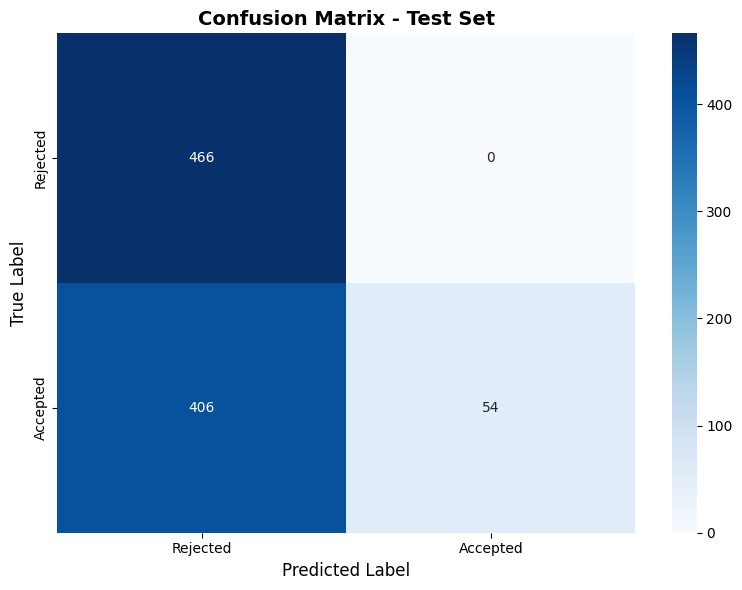


Confusion Matrix Breakdown:
  True Negatives (Correctly predicted Rejected): 466
  False Positives (Incorrectly predicted Accepted): 0
  False Negatives (Incorrectly predicted Rejected): 406
  True Positives (Correctly predicted Accepted): 54


In [38]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Accepted'],
            yticklabels=['Rejected', 'Accepted'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Correctly predicted Rejected): {cm[0,0]}")
print(f"  False Positives (Incorrectly predicted Accepted): {cm[0,1]}")
print(f"  False Negatives (Incorrectly predicted Rejected): {cm[1,0]}")
print(f"  True Positives (Correctly predicted Accepted): {cm[1,1]}")


---


## 10. Analyze Predictions


In [39]:
# Get prediction probabilities
pred_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)
confidence_scores = pred_probs.max(dim=-1).values.numpy()

print("Prediction Confidence Analysis:")
print("="*60)
print(f"  Mean confidence: {confidence_scores.mean():.4f}")
print(f"  Median confidence: {np.median(confidence_scores):.4f}")
print(f"  Min confidence: {confidence_scores.min():.4f}")
print(f"  Max confidence: {confidence_scores.max():.4f}")

# High confidence vs low confidence predictions
high_conf_threshold = 0.9
low_conf_threshold = 0.6

high_conf = (confidence_scores > high_conf_threshold).sum()
low_conf = (confidence_scores < low_conf_threshold).sum()

print(f"\n  High confidence (>{high_conf_threshold}): {high_conf} ({high_conf/len(confidence_scores)*100:.1f}%)")
print(f"  Low confidence (<{low_conf_threshold}): {low_conf} ({low_conf/len(confidence_scores)*100:.1f}%)")


Prediction Confidence Analysis:
  Mean confidence: 0.5978
  Median confidence: 0.5519
  Min confidence: 0.5413
  Max confidence: 0.9974

  High confidence (>0.9): 97 (10.5%)
  Low confidence (<0.6): 828 (89.4%)


In [ ]:
# Analyze mistakes
mistakes_df = test_df.copy().reset_index(drop=True)
mistakes_df['predicted'] = pred_labels
mistakes_df['correct'] = (mistakes_df['label'] == mistakes_df['predicted'])
mistakes_df['confidence'] = confidence_scores

# False positives (predicted Accepted but actually Rejected)
false_positives = mistakes_df[(mistakes_df['label'] == 0) & (mistakes_df['predicted'] == 1)]
# False negatives (predicted Rejected but actually Accepted)
false_negatives = mistakes_df[(mistakes_df['label'] == 1) & (mistakes_df['predicted'] == 0)]

print(f"\nError Analysis:")
print(f"  Correct predictions: {mistakes_df['correct'].sum()} ({mistakes_df['correct'].sum()/len(mistakes_df)*100:.1f}%)")
print(f"  False positives: {len(false_positives)}")
print(f"  False negatives: {len(false_negatives)}")

if len(false_positives) > 0:
    print(f"\n  Example False Positive (wrongly accepted):")
    fp_example = false_positives.iloc[0]
    print(f"    Resume preview: {fp_example['Resume'][:150]}...")
    print(f"    Confidence: {fp_example['confidence']:.3f}")

if len(false_negatives) > 0:
    print(f"\n  Example False Negative (wrongly rejected):")
    fn_example = false_negatives.iloc[0]
    print(f"    Resume preview: {fn_example['Resume'][:150]}...")
    print(f"    Confidence: {fn_example['confidence']:.3f}")



Error Analysis:
  Correct predictions: 613 (60.2%)
  False positives: 233
  False negatives: 172

  Example False Positive (wrongly accepted):
    Resume preview: Here's a professional resume for Herbert Campos, a UI Engineer candidate:

Herbert Campos
UI Engineer

Contact Information:

* Email: [herbert.campos@...
    Confidence: 0.533

  Example False Negative (wrongly rejected):
    Resume preview: Here's a professional resume for Matthew Sexton:

Matthew Sexton
Cloud Engineer

Contact Information:

* Email: [matthew.sexton@email.com](mailto:matt...
    Confidence: 0.523


---


## 11. Save Trained Model


In [ ]:
# Save the final model and tokenizer
final_model_path = MODELS_DIR / 'resume_classifier_final'
final_model_path.mkdir(parents=True, exist_ok=True)

print(f"Saving model to: {final_model_path}")

# Save model
model.save_pretrained(str(final_model_path))
tokenizer.save_pretrained(str(final_model_path))

print("✓ Model saved successfully")
print(f"✓ Location: {final_model_path.absolute()}")

# Save model configuration
model_config = {
    'model_name': model_name,
    'num_labels': 2,
    'max_length': 512,
    'label_map': label_map,
    'training_samples': len(train_df),
    'validation_samples': len(val_df),
    'test_samples': len(test_df),
    'test_metrics': {
        'accuracy': float(test_metrics['eval_accuracy']),
        'precision': float(test_metrics['eval_precision']),
        'recall': float(test_metrics['eval_recall']),
        'f1': float(test_metrics['eval_f1'])
    },
    'training_config': {
        'epochs': training_args.num_train_epochs,
        'batch_size': training_args.per_device_train_batch_size,
        'learning_rate': training_args.learning_rate
    }
}

config_path = final_model_path / 'model_info.json'
with open(config_path, 'w') as f:
    json.dump(model_config, f, indent=2)

print(f"✓ Model configuration saved: {config_path}")


Saving model to: ..\data\models\resume_classifier_final
✓ Model saved successfully
✓ Location: c:\Users\reza\Desktop\prj\resume-analyzer\notebooks\..\data\models\resume_classifier_final
✓ Model configuration saved: ..\data\models\resume_classifier_final\model_info.json


---


## 12. Test Model Inference

Test the saved model with new examples.


In [ ]:
# Define inference function
def predict_resume(resume_text: str, model, tokenizer, device) -> dict:
    """
    Predict if a resume will be accepted or rejected.
    
    Args:
        resume_text: Resume text
        model: Trained model
        tokenizer: Tokenizer
        device: Device to run inference on
    
    Returns:
        Dictionary with prediction and confidence
    """
    # Tokenize
    inputs = tokenizer(
        resume_text,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    
    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        prediction = torch.argmax(probs, dim=-1).item()
        confidence = probs[0, prediction].item()
    
    return {
        'prediction': prediction,
        'decision': 'Accepted' if prediction == 1 else 'Rejected',
        'confidence': confidence,
        'prob_rejected': probs[0, 0].item(),
        'prob_accepted': probs[0, 1].item()
    }


# Test with sample resumes
test_resumes = [
    """
    Jane Smith
    Senior Software Engineer
    
    EXPERIENCE
    - 8 years of Python development
    - Led teams of 10+ engineers
    - Expertise in AWS, Docker, Kubernetes
    - Published 5 technical papers
    
    EDUCATION
    PhD in Computer Science, MIT
    MS in Data Science, Stanford
    
    SKILLS
    Python, Java, TensorFlow, PyTorch, React
    """,
    
    """
    John Doe
    
    Experience: worked with computers
    Education: high school
    Skills: Microsoft Word
    """
]

print("Testing Model Inference")
print("="*80)

for i, resume in enumerate(test_resumes, 1):
    print(f"\nTest Resume #{i}:")
    print("-" * 60)
    print(resume[:100].strip() + "...")
    
    result = predict_resume(resume, model, tokenizer, device)
    
    print(f"\nPrediction: {result['decision']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"  Probability Rejected: {result['prob_rejected']:.2%}")
    print(f"  Probability Accepted: {result['prob_accepted']:.2%}")
    print("=" * 60)

print("\n✓ Model inference working correctly")


Testing Model Inference

Test Resume #1:
------------------------------------------------------------
Jane Smith
    Senior Software Engineer

    EXPERIENCE
    - 8 years of Python development...

Prediction: Rejected
Confidence: 62.20%
  Probability Rejected: 62.20%
  Probability Accepted: 37.80%

Test Resume #2:
------------------------------------------------------------
John Doe

    Experience: worked with computers
    Education: high school
    Skills: Microsof...

Prediction: Rejected
Confidence: 50.17%
  Probability Rejected: 50.17%
  Probability Accepted: 49.83%

✓ Model inference working correctly


---


## 13. Production Code

The following class is ready for extraction into production modules.


In [ ]:
# PRODUCTION CODE

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pathlib import Path


class ResumeClassifier:
    """
    Fine-tuned BERT/DistilBERT model for resume classification.
    """
    
    def __init__(self, model_path: str):
        """
        Initialize the classifier with a trained model.
        
        Args:
            model_path: Path to saved model directory
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = self.model.to(self.device)
        self.model.eval()
    
    def predict(self, resume_text: str) -> dict:
        """
        Predict if a resume will be accepted or rejected.
        
        Args:
            resume_text: Resume text to classify
        
        Returns:
            Dictionary with prediction, confidence, and probabilities
        """
        # Tokenize
        inputs = self.tokenizer(
            resume_text,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )
        
        # Move to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        # Get prediction
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            prediction = torch.argmax(probs, dim=-1).item()
            confidence = probs[0, prediction].item()
        
        return {
            'prediction': prediction,
            'decision': 'Accepted' if prediction == 1 else 'Rejected',
            'confidence': confidence,
            'prob_rejected': probs[0, 0].item(),
            'prob_accepted': probs[0, 1].item()
        }
    
    def batch_predict(self, resume_texts: list) -> list:
        """
        Predict classifications for multiple resumes.
        
        Args:
            resume_texts: List of resume texts
        
        Returns:
            List of prediction dictionaries
        """
        results = []
        for resume_text in resume_texts:
            result = self.predict(resume_text)
            results.append(result)
        return results


print("✓ Production class defined:")
print("  - ResumeClassifier class")
print("\nMethods:")
print("  - predict(resume_text)")
print("  - batch_predict(resume_texts)")
print("\nThis class is ready to be extracted to models/resume_classifier.py")


✓ Production class defined:
  - ResumeClassifier class

Methods:
  - predict(resume_text)
  - batch_predict(resume_texts)

This class is ready to be extracted to models/resume_classifier.py


In [ ]:
# Test the production class
print("\nTesting Production Class:")
print("="*60)

# Initialize classifier with saved model
classifier = ResumeClassifier(str(final_model_path))

# Test prediction
test_resume = """
Senior Data Scientist with 7 years of experience.
Expert in Python, TensorFlow, PyTorch, and AWS.
PhD in Machine Learning from Stanford University.
Published 10+ research papers in top conferences.
"""

result = classifier.predict(test_resume)

print(f"\nTest Resume:")
print(test_resume[:100] + "...")
print(f"\nPrediction: {result['decision']}")
print(f"Confidence: {result['confidence']:.2%}")

print("\n✓ Production class tested successfully")



Testing Production Class:

Test Resume:

Senior Data Scientist with 7 years of experience.
Expert in Python, TensorFlow, PyTorch, and AWS.
P...

Prediction: Rejected
Confidence: 63.81%

✓ Production class tested successfully
